In [23]:
import utils as lib

from PIL import Image
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from lime import lime_tabular
from IPython.display import display, HTML

import fairlearn.metrics as flm
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

warnings.filterwarnings("ignore", category=FutureWarning)

# Welcome to the FIM Bank

At the FIM Bank we have different tiers of customers. People with an estimated income of more than 50k a year receive special treatment with superior products and better credit conditions. However, we keep struggling with our ranking policy. Some of our clients turned out to have lower incomes than expected which lead to severe losses. Other clientes complained about unfair treatment and accused our account managers of discrimination.

## Current Process

Our current process looks like this:
* People apply for a credit and provide their data: demographics, education, occupation, income, financial history (e.g., Schufa-Auskunft).
* A loan officer estimates the income of the applicant based on past experience and sympathy.
* If the applicant is expected to earn more than 50k, he or she is granted superior status; otherwise, he or she is offered less favorable conditions.

## Your Mission

We need you to revise our ranking process. Therefore, you should design a ML model that selects the "right" clients for superior status. Develop a simple ML model that makes a binary decision about applicants' customer tiers, as depicted in this sketch. Positive means income >50k, negative means income <=50k.

<div style="display: flex; justify-content: center; align-items: center;">
  <div style="display: flex; justify-content: center; align-items: center; padding: 10px; background-color: white;">
    <img src="img\Classification.jpg" style="max-height: 500px;">
  </div>
</div>

The ranking decision should fulfill three objectives. You will be confronted with several normative and economic tradeoff decisions along the way. **Please make notes about your tradeoff decisions or engage in a discussion with your colleagues.**

### Business Objective
**To maximize our profits you should correctly identify and select the clients that deserve superior conditions.**

### Fairness Objective
**At the same time, please make sure that everyone is treated fairly. It is up to you to determine what fair is - you can follow legal requirements, social norms, or academic insights. Just make sure to deliver it convincingly.**

### Transparency Objective
**The model should make justifiable decisions and allow for human supervision.**

# Data Understanding: These are our clients
Luckily, we gathered historical data on our clients' income. Here you find details about data collection and feature descriptions: https://archive.ics.uci.edu/dataset/2/adult
* Familiarize yourself with the data at hand. 
* Take a look at the features and labels. 
* Plot some feature distributions.

## Data Overview

In [24]:
# load dataset with slight formal preprocessing
dataset = (
    pd.read_csv("Dataset.csv", sep=';', encoding='ISO-8859-1')
    .rename(columns={"ï»¿Age": "age"})
    .drop(columns=["fnlwgt", "relationship", "education"]) # drop redundant variables
)

In [25]:
# a glimpse into the dataset
print("\nThe dataset contains", dataset.shape[0], "data points and", dataset.shape[1], "features.\n")
dataset.head()


The dataset contains 32561 data points and 12 features.



,age,workclass,education-num,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Cuba,<=50K


In [26]:
# mean, standard deviation, min/max values, and quantiles of the numerical features
dataset.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


##  Feature Overview

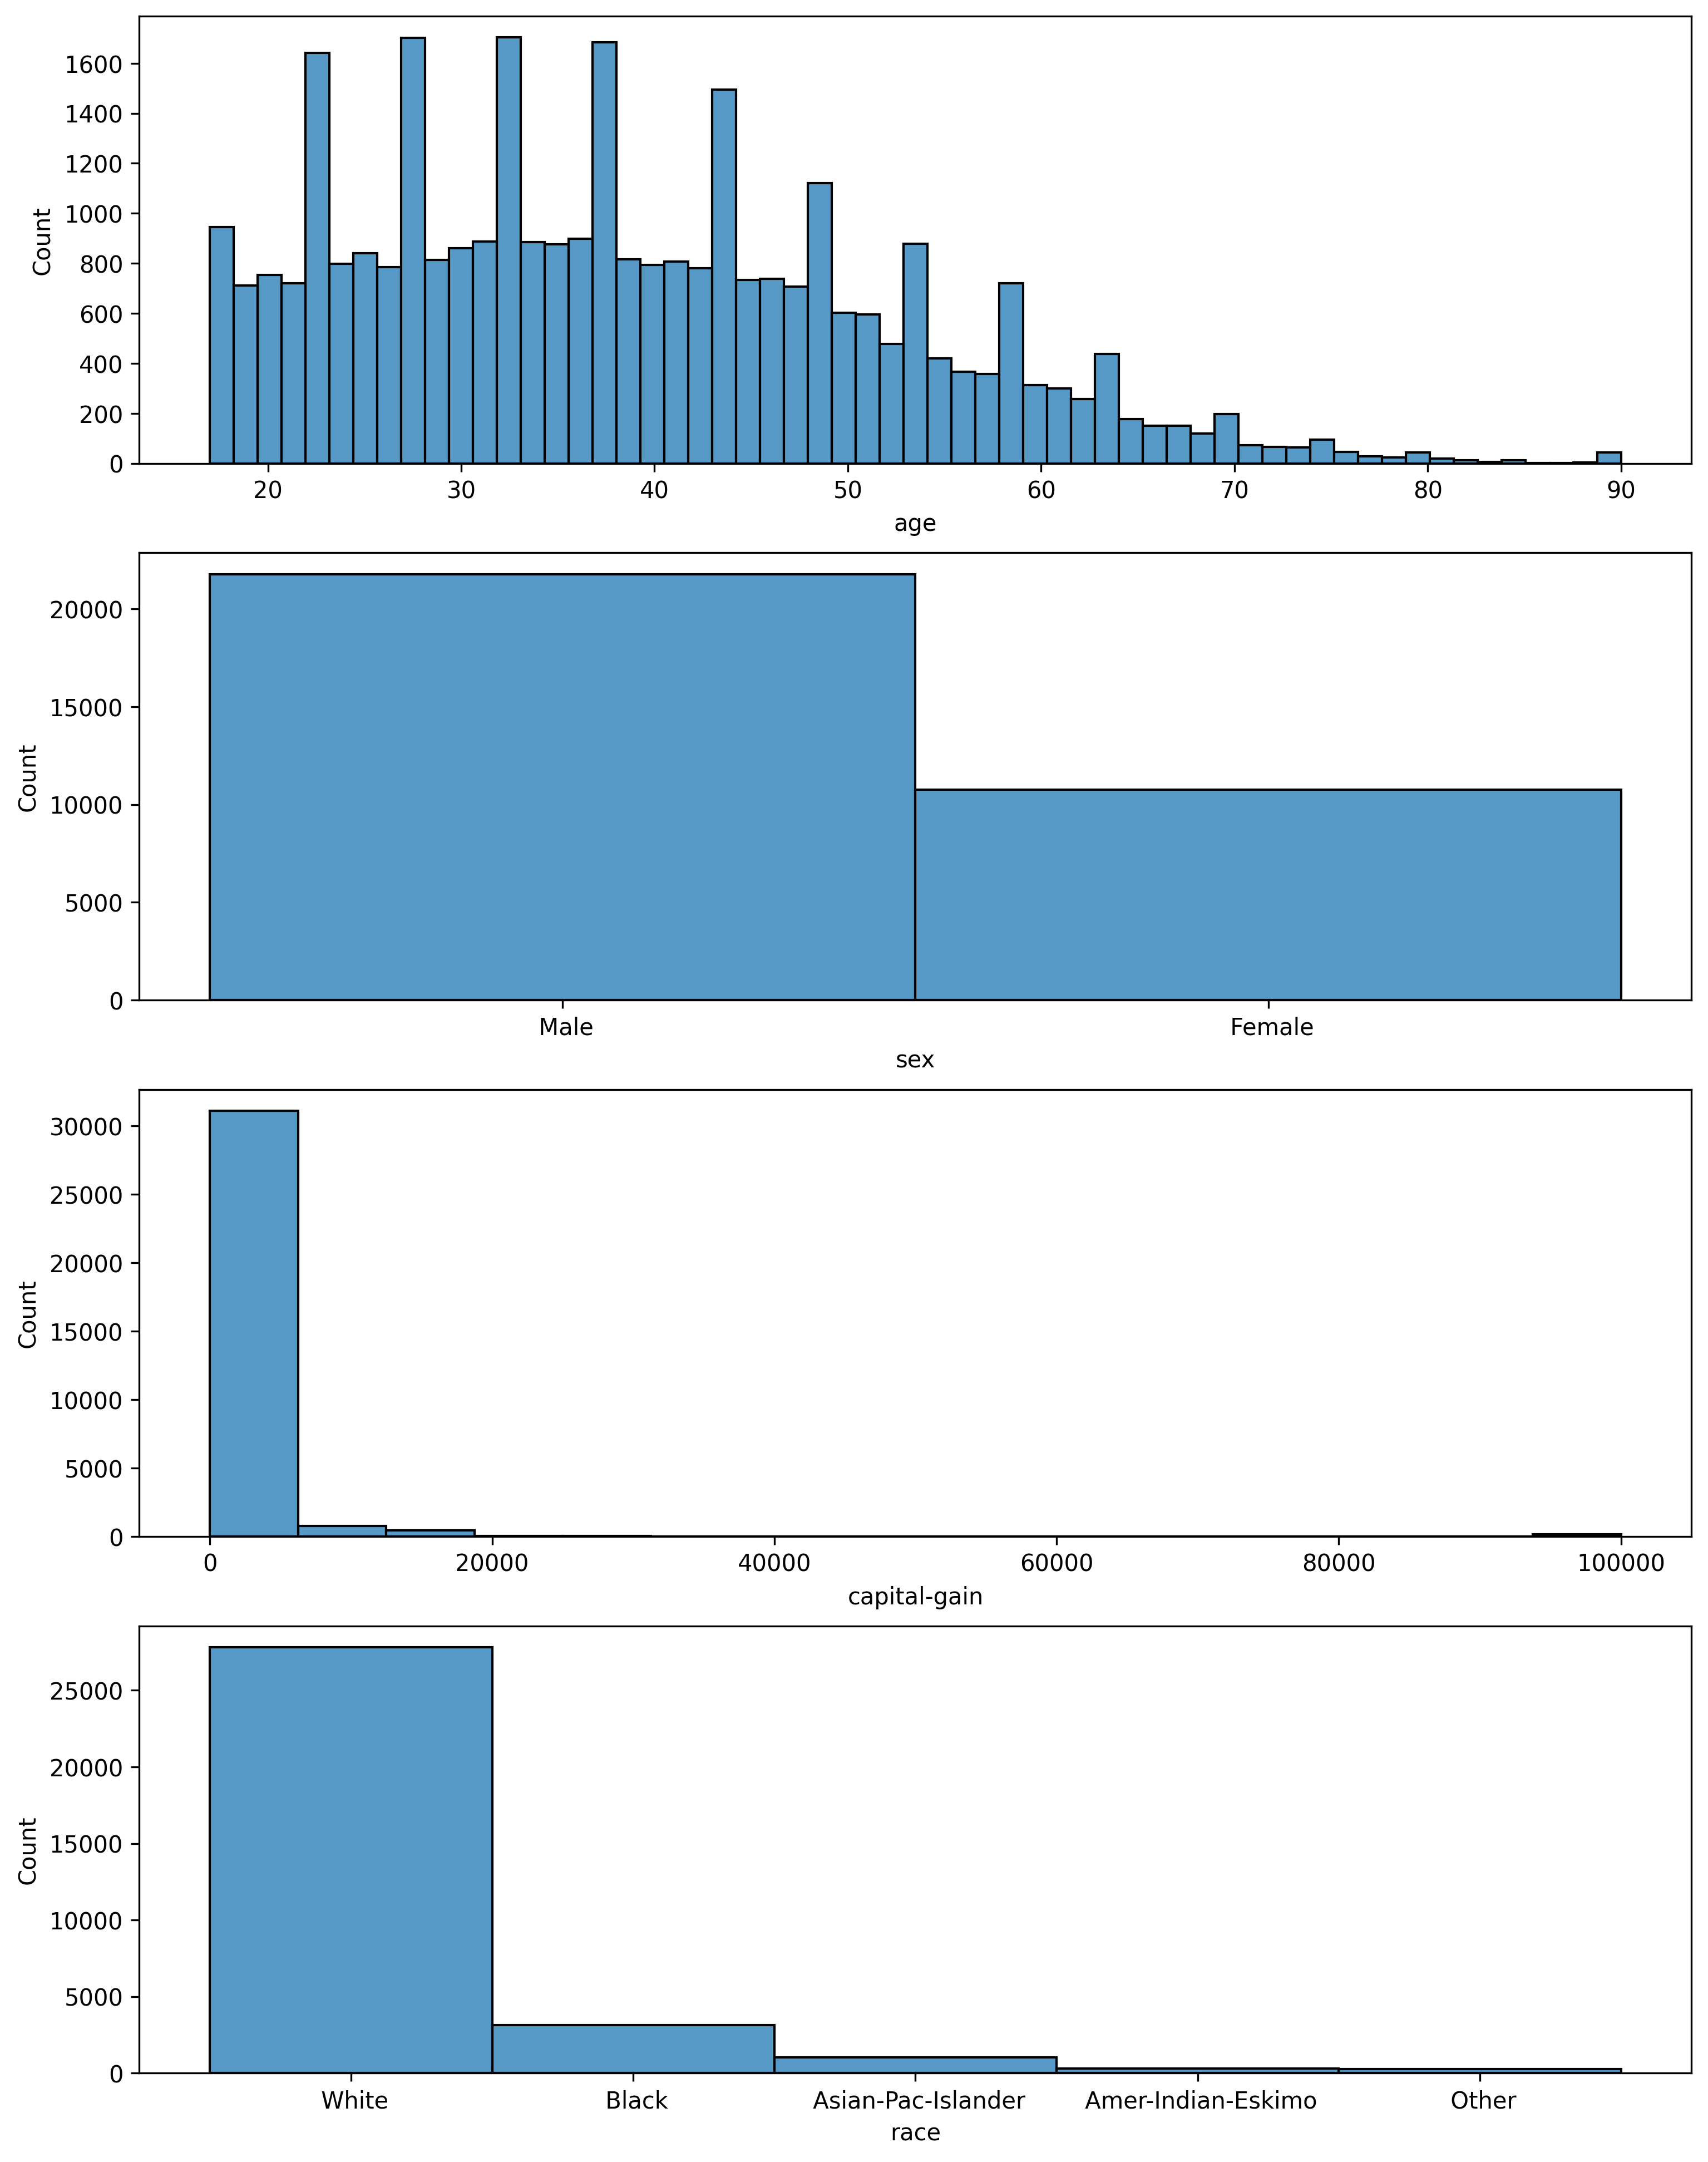

In [27]:
# enter the feature names you want to visualize
feature_names = ["age", "sex", "capital-gain", "race"]
lib.show_distribution(dataset, feature_names=feature_names)

# Data Preprocessing

## Missing values
Before using our data to train a model, we need to some basic data preprocessing. Your decisions at this step might already change the outcome of your model!

                n_miss  ratio
occupation        1843   5.66
workclass         1836   5.64
native-country     583   1.79


<Axes: >

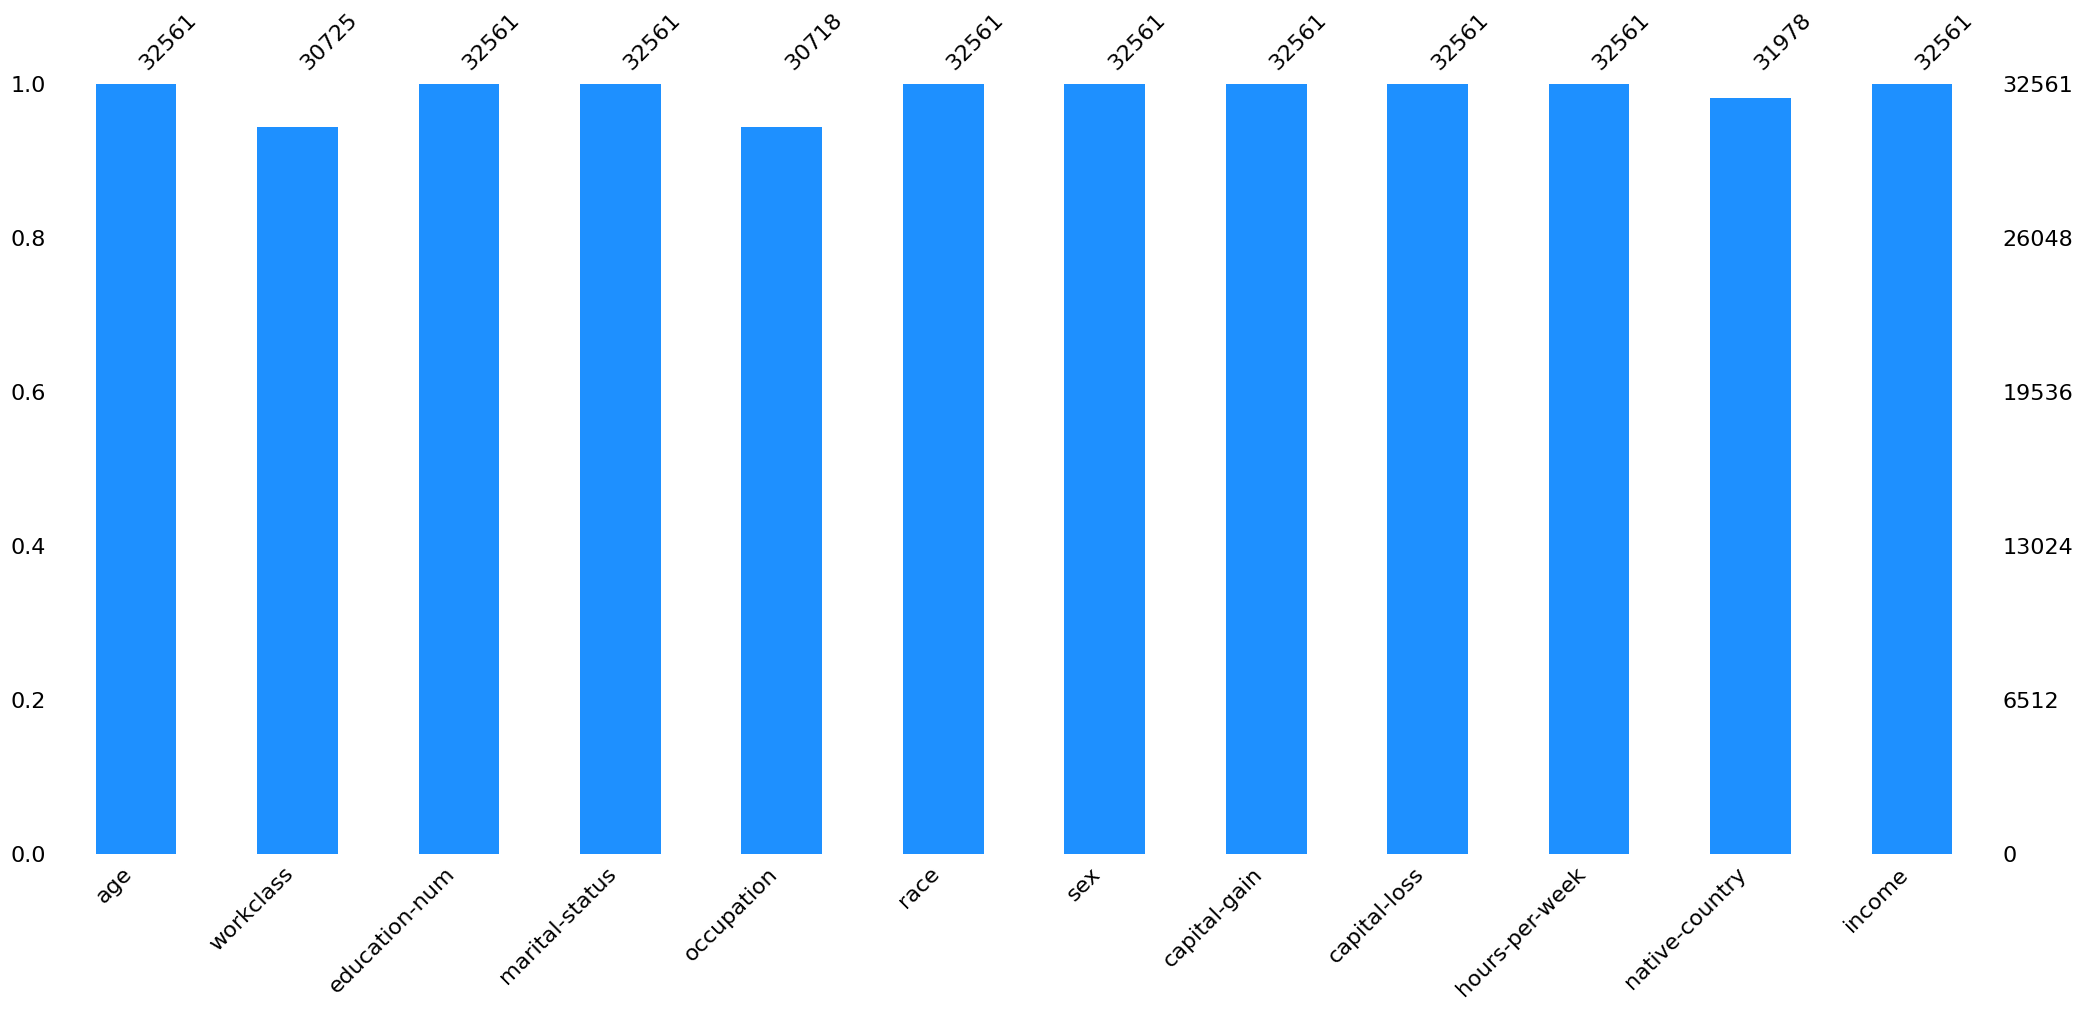

In [28]:
features = ["age", "workclass", "education-num", "marital-status", "occupation", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

# Generate a summary table of missing values for each column in the DataFrame.
missing_values = lib.identify_missing_values(dataset, features)

# Display a bar chart that shows the data availability for each feature
msno.bar(dataset, color="dodgerblue")

In [29]:
# strategy to handle missing values: mean
missing_values_strategy = 'mean'

# handle missing values based on the selected strategy
dataset, features = lib.handle_missing_data(dataset, features, missing_values_strategy, missing_values)

# Check if there are still any missing values in the entire DataFrame
dataset.isnull().values.any()

# Convert 'object' data types to 'float' if the column contains numeric values
lib.transformObjectToFloat(dataset)

## Normalization
To enable a meaningful processing of all the features, we need to encode and scale them.

### Numerical Features

In [30]:
numerical_features = ["race", "sex", "age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

numericaldata = dataset[numerical_features]
target = 'income'
targetdata = dataset[target]

# binary encoding for female (0) and male (1)
sex_mapping = {' Female': 0, ' Male': 1}
numericaldata.loc[:, "sex"] = numericaldata["sex"].replace(sex_mapping)

# for simplicity we differentiate between white (0) and "others" (1)
race_mapping = {' White': 0, ' Black': 1, ' Asian-Pac-Islander': 1, ' Amer-Indian-Eskimo': 1, ' Other': 1}
numericaldata.loc[:, "race"] = numericaldata["race"].replace(race_mapping)

# minmax because we can not assume standard distribution for our numerical features
scaler = MinMaxScaler()
numericaldata_scaled = scaler.fit_transform(numericaldata)

# income should not be transformed as it is the target variable
target_mapping = {' <=50K': 0, ' >50K': 1}
targetdata = targetdata.replace(target_mapping)

# the result is a NumPy-Array, so let's convert it back into a DataFrame
numericaldata = pd.DataFrame(numericaldata_scaled, columns=numericaldata.columns)

### Categorical Features

In [31]:
categorical_features = ["workclass", "marital-status", "occupation", "native-country"]

categoricaldata = dataset[categorical_features]

# one-hot encoding for categorical features
data, columns = lib.OneHotEncoder(categoricaldata, categorical_features)

# merge data
combined_data = pd.concat((numericaldata, data, targetdata), axis=1)

## Sensitive Features

<span style="color: blue; font-weight: bold;">TASK 1: Do you want to include or exclude sensitive features for the training later on? You can choose to treat them with a special careful focus or remove them entirely.</span>
* `sex`
* `age`
* `race`

In [32]:
# Which (potentially) sensitive features do you want to focus on explicitly?
selected_sensitive_features = ["race", "sex", "age"]

# Do you want to remove any sensitive features?
remove = []

# remove selected sensitive features and create a separate decoded dataframe for the sensitive features (required later on)
dataset, sensitive_data = lib.remove_sensitive_features(combined_data, remove, selected_sensitive_features, features)

display(dataset.head())
display(sensitive_data.head())

,race,sex,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income
0,0.0,1.0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,1.0,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.0,1.0,0.287671,0.533333,0.00000,0.0,0.397959,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,1.0,0.493151,0.400000,0.00000,0.0,0.397959,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,0.0,0.150685,0.800000,0.00000,0.0,0.397959,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,race,sex,age
0,White,Male,30-60
1,White,Male,30-60
2,White,Male,30-60
3,Other,Male,30-60
4,Other,Female,18-30


Notes:

* 

## Correlation matrix

<span style="color: blue; font-weight: bold;"> TASK 2: Take a look at the correlations with sensitive attributes. What implications could this have for fairness? If you have removed some sensitive features, would you like to remove correlated features as well?

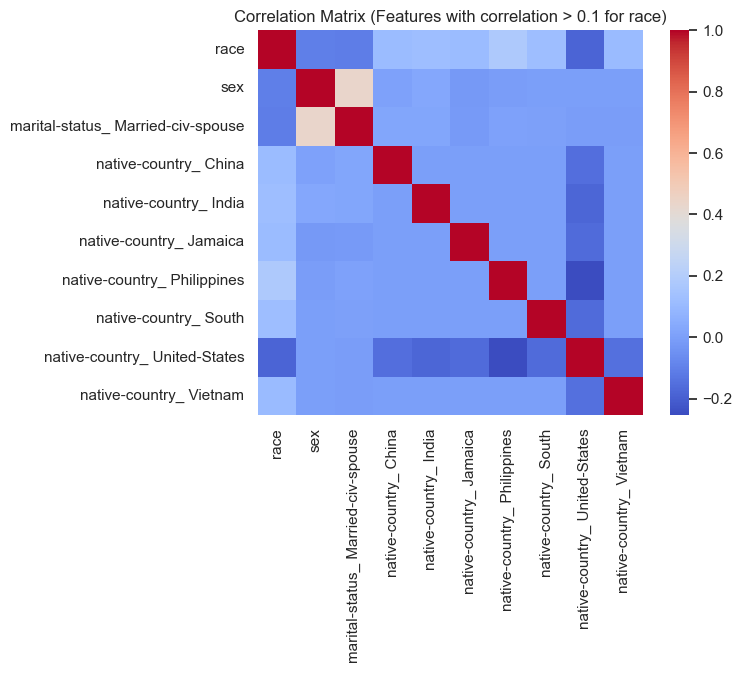

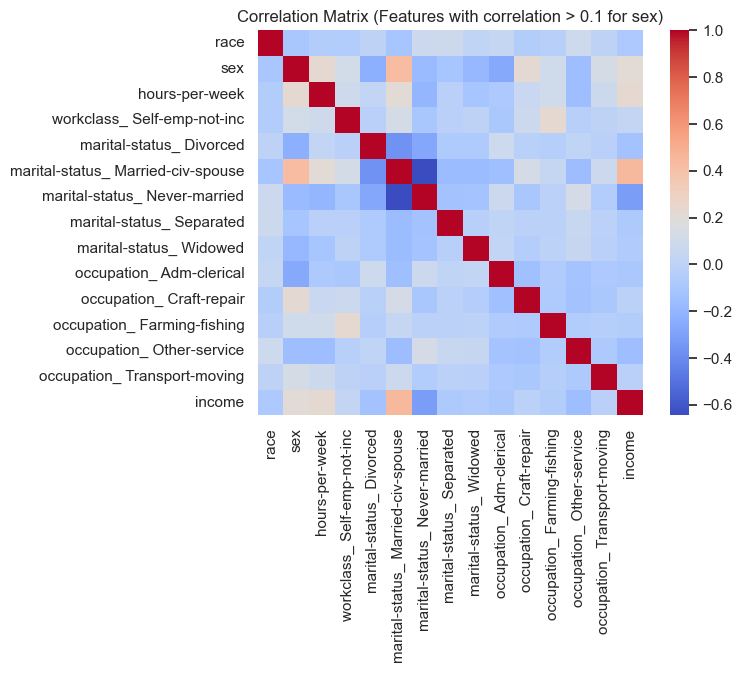

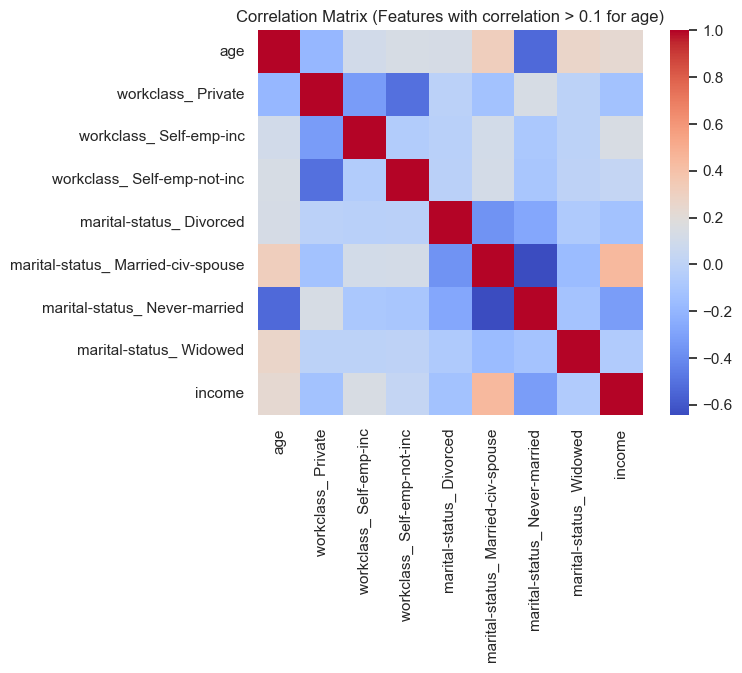

In [33]:
# compute correlation matrix for all features
correlation_matrix = combined_data.corr()
correlation_threshold = 0.1 # set threshold for minimum correlation with sensitive attributes

# leave out uncorrelated features below threshold for overview
for feature in selected_sensitive_features:
    correlation = correlation_matrix[feature].abs() > correlation_threshold
    correlation_subset = correlation_matrix.loc[correlation, correlation]

# plot reduced correlation matrix
    sns.set(style="white")
    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_subset, ax=plt.gca(), cmap="coolwarm", fmt=".2f", square=True)
    plt.title(f"Correlation Matrix (Features with correlation > {correlation_threshold} for {feature})")
    plt.show()

## Feature Selection
To reduce our feature space to a manageable size, we need to select the most relevant features. `Lasso (Least Absolute Shrinkage and Selection Operator)` is a regression method that attempts to reduce the number of features used in a model by setting some of the coefficients to zero. Features whose coefficients have been reduced to zero are not included in the model. In addition to ordinary linear regression, it adds a cost function (loss function) that is to be minimized. The **alpha value** stands for the regularization strength, which controls the effects of the regularization on the model.

In [34]:
# choose the feature selection strategy
selection_strategy = 'Lasso'

alpha = 0.01               # needed for Lasso regression
n_features = 5             # needed for PCA: number of features

# make sure the sensitive features remain in the features
ready_data = lib.select_the_features(combined_data, selection_strategy, alpha, n_features, target, selected_sensitive_features)
# check whether our preprocessed data are ready for training
ready_data.head()

,race,sex,age,education-num,marital-status_ Married-civ-spouse,marital-status_ Never-married,occupation_ Exec-managerial,occupation_ Prof-specialty,income
0,0.0,1.0,0.301370,0.800000,0,1,0,0,0
1,0.0,1.0,0.452055,0.800000,1,0,1,0,0
2,0.0,1.0,0.287671,0.533333,0,0,0,0,0
3,1.0,1.0,0.493151,0.400000,1,0,0,0,0
4,1.0,0.0,0.150685,0.800000,1,0,0,1,0


# Model Training

In [35]:
# define training and target features
X = ready_data.drop(target, axis=1)
Y = ready_data[target]

# train, test split. 
# an additional split is performed for A_train and A_test wich include the sensitive attributes, which will be required later on)
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X, Y, sensitive_data, test_size=0.2, random_state=42)

<span style="color: blue; font-weight: bold;">TASK 3: Which training algorithm do you want to use? How do you want to weight classes (we will return to this after the first evaluation)?</span>

* `Linear Regression` classifies indviduals based on a probability threshold. Features are additive and directly interpretable.

* `Decision Trees` partition the dataset into subgroups and create rules for each node based on the characteristics. For a small number of nodes, decision trees are intuitively interpretable.

* `Random Forest` is an ensemble method based on decision trees. It creates a large number of decision trees and combines their predictions to achieve more robust and accurate regression results. However, interpretation is more difficult and imprecise.

* `MLP Classifiers` are basically artificial neural networks and super powerful in learning non-linear relationships. However, we need to rely on model-agnostic XAI tools like LIME to approximate feature importance. Also, in our use case it is not possible to apply unfairness mitigation on MLP Classifiers.

## Parameter Tuning
Choose one model for training and specify the parameters. Ignore the rest of the models.

In [36]:
# model_name = "Linear Regression"

class_weight = {
    0:1/6, # weight for negative class (<= 50K)
    1:5/6} # weight for positive class (>50K)
lr = RidgeClassifier(alpha=0, class_weight=class_weight).fit(X_train, Y_train)

In [37]:
# model_name = "Decision Tree"

max_depth = 10 # maximum level of decision nodes, the higher the more complex (but also the more prone to overfitting)
class_weight = {
    0:1/6, # weight for negative class (<= 50K)
    1:5/6} # weight for positive class (>50K)
dt = DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight).fit(X_train, Y_train)

In [38]:
model_name = "Random Forest"

n_estimators = 100 # number of decision trees used for the ensemble classifer
max_depth = 10 # maximum level of decision nodes, the higher the more complex (but also the more prone to overfitting)
class_weight = {
    0:1/6, # weight for negative class (<= 50K)
    1:5/6} # weight for positive class (>50K)
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight).fit(X_train, Y_train)

In [39]:
# model_name = "MLP Classifier"

hidden_layer_sizes = 10 # the number of hidden layers represents the complexity of your ANN: from 1 (simple) to 100 (complex)
max_iter = 200 # manual stopping criteria to accelerate training or prevent overfitting
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter).fit(X_train, Y_train)

## Model Selection

In [40]:
# select your model
selected_model = rf

Y_pred = selected_model.predict(X_test)
Y_pred

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

Notes:

* 

# Evaluation

## Performance Metrics
Now that we have obtained our predictions, it is time to critically evaluate our performance. As you now, there is a broad range of performance metrics:

* `Confusion Matrix` is a tabular representation of the true and predicted classifications. It enables a detailed analysis of the model performance.

* `Accuracy` measures the percentage of correct predictions in relation to the total number of predictions.

* `Precision` measures the percentage of true positive predictions (TP) in relation to all positive classifications (TP + FP). It is particularly important in situations where overestimated labels (false positives) are costly.

* `Recall` measures the percentage of true positive predictions (TP) in relation to all true instances (TP+FN). It is particularly important in situations where underestimated labels (false negatives) are costly.

* `F-Beta-Score` provides a balance between precision and recall, where Beta specifies the ratio of recall importance to precision importance. For beta = 1, precision and recall are weighted equally.

<span style="color: blue; font-weight: bold;">TASK 4: How do you evaluate your model's performance? Are there any improvements required?</span>

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Luca\AppData\Local\Temp\ipykernel_4700\1752955138.py:2: SyntaxWarning: invalid escape sequence '\c'
  img = Image.open("img\confusion_matrix.png")


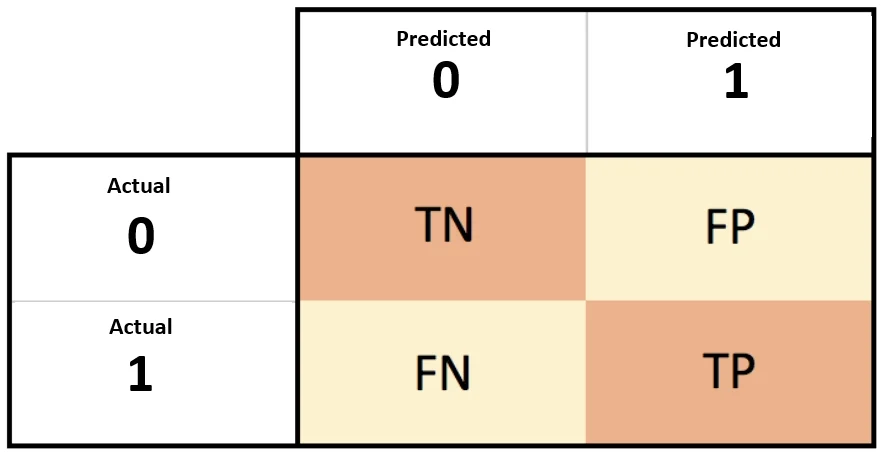

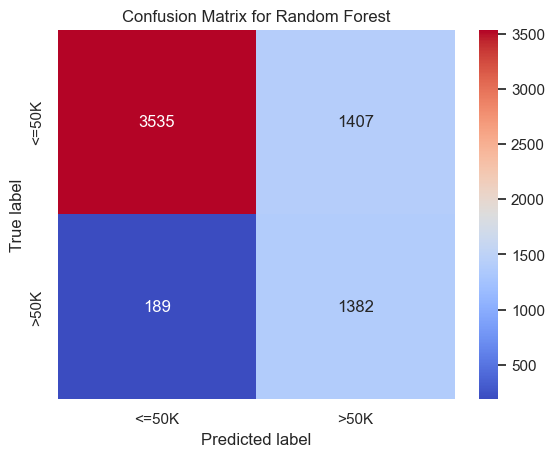

Accuracy: 0.7549516351911562
Precision: 0.7223831135745423
Recall: 0.7974959562754818
F-1-Score: 0.6339449541284404


In [41]:
# confusion matrix
img = Image.open("img\confusion_matrix.png")
display(img, )
class_labels = ["<=50K", ">50K"]
cm = confusion_matrix(Y_test, Y_pred)
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', annot_kws={"size": 12}, xticklabels=class_labels, yticklabels=class_labels)
heatmap.set_xlabel("Predicted label")
heatmap.set_ylabel("True label")
plt.title(f"Confusion Matrix for {model_name}")
plt.show()

# accuracy, precision, recall
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro')) 

# f-beta-score (a higher beta gives more weight to recall)
beta = 1
print(f"F-{beta}-Score:", fbeta_score(Y_test, Y_pred, beta=beta))

Notes:

* 

## Interpretability

<span style="color: blue; font-weight: bold;">TASK 5: How do you evaluate your model's reasoning? Are there any improvements required?</span>

### Feature Importance
Feature importance should always be interpreted with caution because it can be imprecise and does not tell us *how* the features are used. However, it can give us a broad indication of how the model comes to its conclusions.
* `Linear Regression`: Feature importance can be directly obtained from the **coefficients**. Remember that our feature encoding was 0 for white (vs. 1 for others) and 0 for women (vs. 1 for men)
* `Decision Tree` and `Random Forest`: Feature importance is measured by the amount of reduction in the Gini **impurity** (see decision tree above). However, this only includes absolute values and does not give an indication about the features "direction".
* `MLP Classifier`: due to the blackbox behavior of ANNs, we need to rely on **LIME** to provide local feature importance (of selected individuals). In this case, the feauture importance refers to a random instance. Feature and Value describe the individual's feature values. Prediction probabilities specify the classification certainty. The bar chart approximates each feature's contribution to the classification outcome. Run the method a few times to get an intuition for LIME explanations.

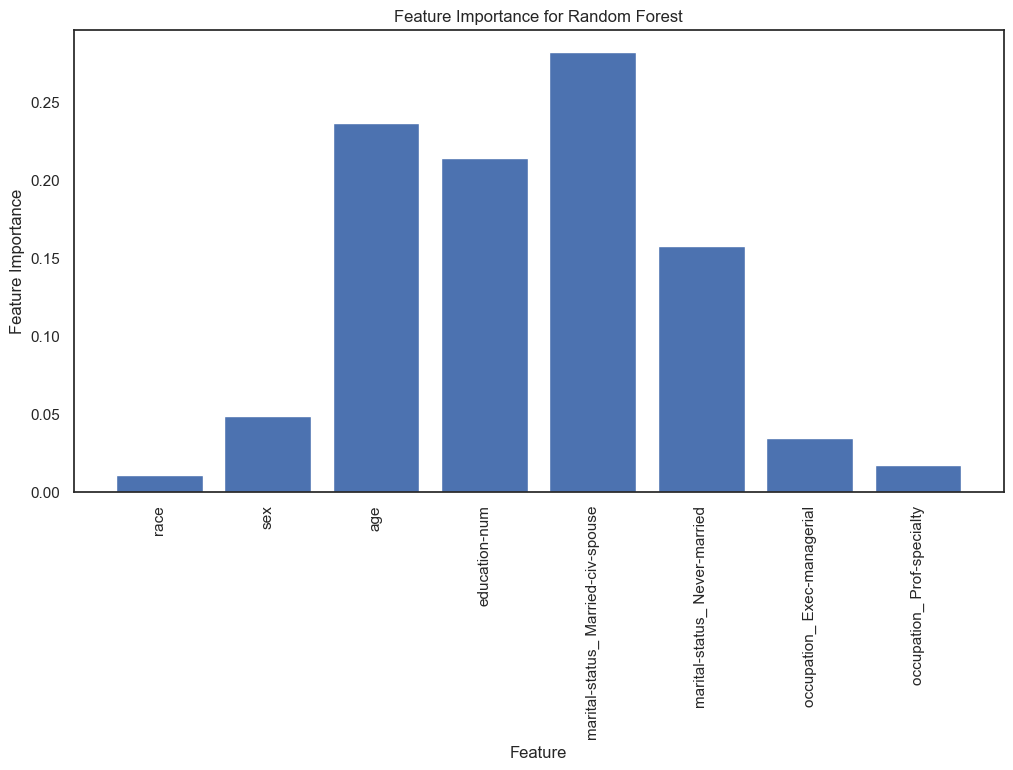

In [42]:
# feature importance
lib.feature_importance(selected_model, X_train, X_test, selected_sensitive_features, class_labels)

### Decision Tree
Decision trees can have meaningful decision rules that humans are able to interpret. However, it is not always too intuitive. Here are some explanations for the lines of each box:
* **First line**: decision rule with feature name and feature threshold
* **Second line**: Gini scores quantify the purity of a node, i.e., how dispersely the samples are distributed. The purer the node the darker the color.
* **Third line**: samples show the proportion of total samples handled in the current node
* **Fourth line**: distribution of how many samples fall into each class (left value refers to <=50K, the right value to >50K)
* **Fifth line**: majority class of the samples handled in the current node

In [43]:
# decision tree
if selected_model == dt:    
    fig = plt.figure(figsize=(16, 8))
    plot_tree(dt, feature_names = features, class_names = class_labels, max_depth=3, fontsize=9, proportion=True, filled=True, rounded=True)

Notes:

* 

## Fairness
You learned that performance is not the only criterion to evaluate. For example, high accuracy can still introduce imbalanced effects for demographic groups. Below is a list of available group fairness metrics that you can select from:

- `accuracy` compares the model's accuracy between sensitive groups
- `selection_rate` compares the rate of positively classified samples (corresponds to **demographic parity**)
- `true positive rate`: difference between true positive rates (corresponds to **equality of opportunity**)
- `false positive rate`: difference between false positive rates (in combination with the true positive rate this corresponds to **equalized odds**)

<span style="color: blue; font-weight: bold;">TASK 6: How do you evaluate your model's fairness? How does it compare to your colleagues' models? Are there any interventions required?</span>

In [44]:
# select the fairness metrics you want to evaluate
fairness_metrics = {
    "accuracy": accuracy_score,
    "selection_rate": flm.selection_rate,
    "false_positive_rate": flm.false_positive_rate,
    "false_negative_rate": flm.false_negative_rate
}

Differences for feature race:
 accuracy               0.096314
selection_rate         0.216972
false_positive_rate    0.163198
false_negative_rate    0.136912
dtype: float64


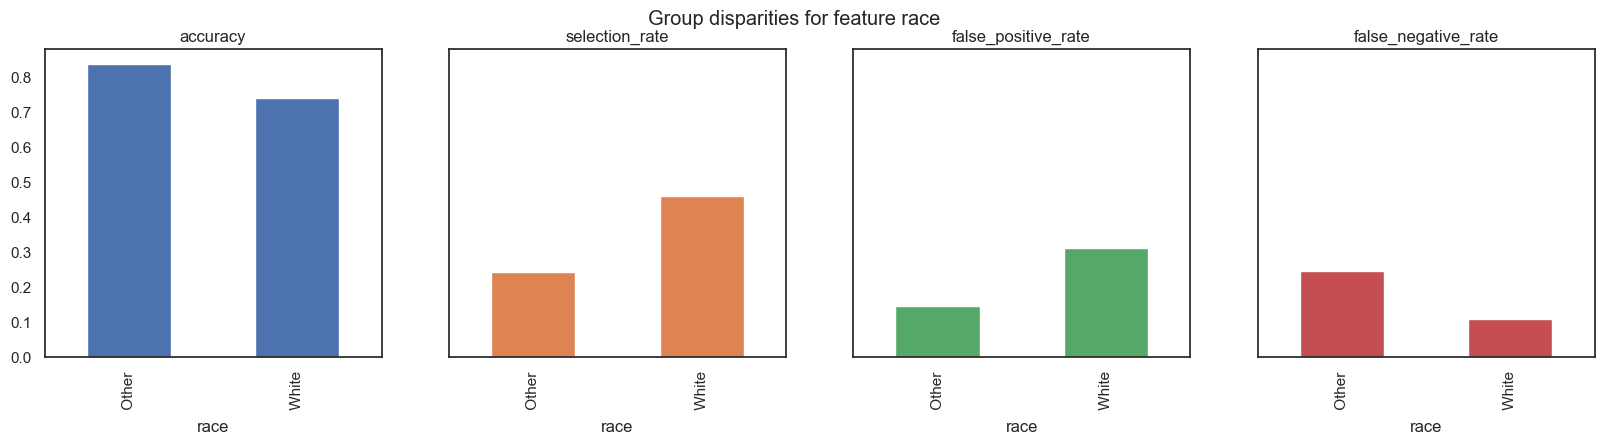

Differences for feature sex:
 accuracy               0.170369
selection_rate         0.377366
false_positive_rate    0.284221
false_negative_rate    0.211490
dtype: float64


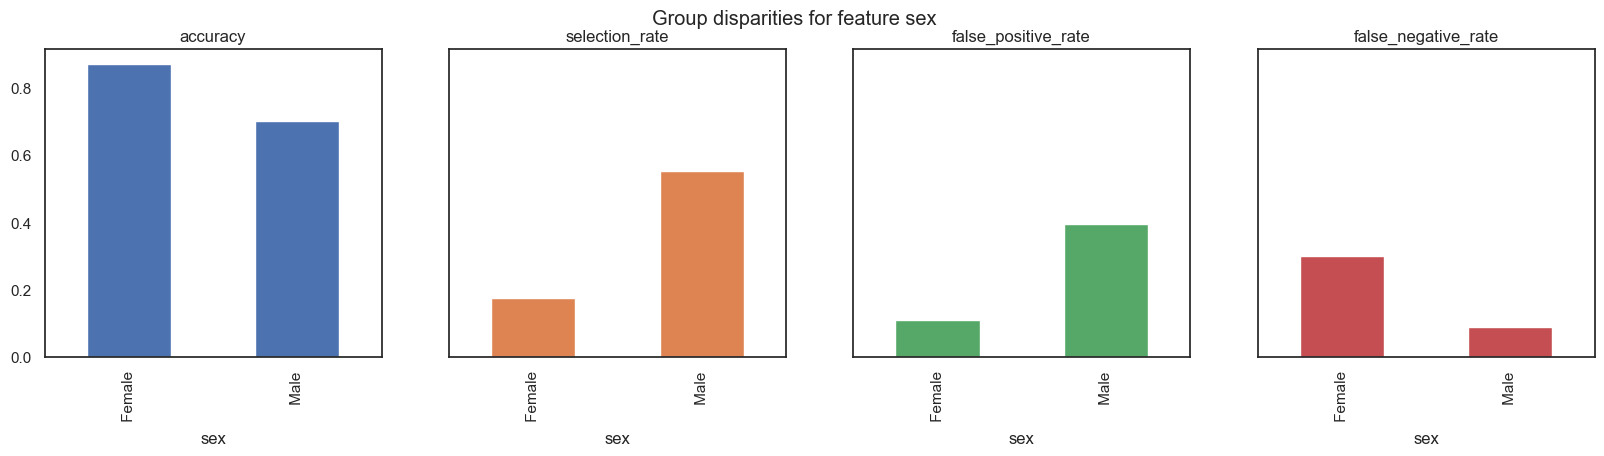

Differences for feature age:
 accuracy               0.235692
selection_rate         0.486031
false_positive_rate    0.346161
false_negative_rate    0.381358
dtype: float64


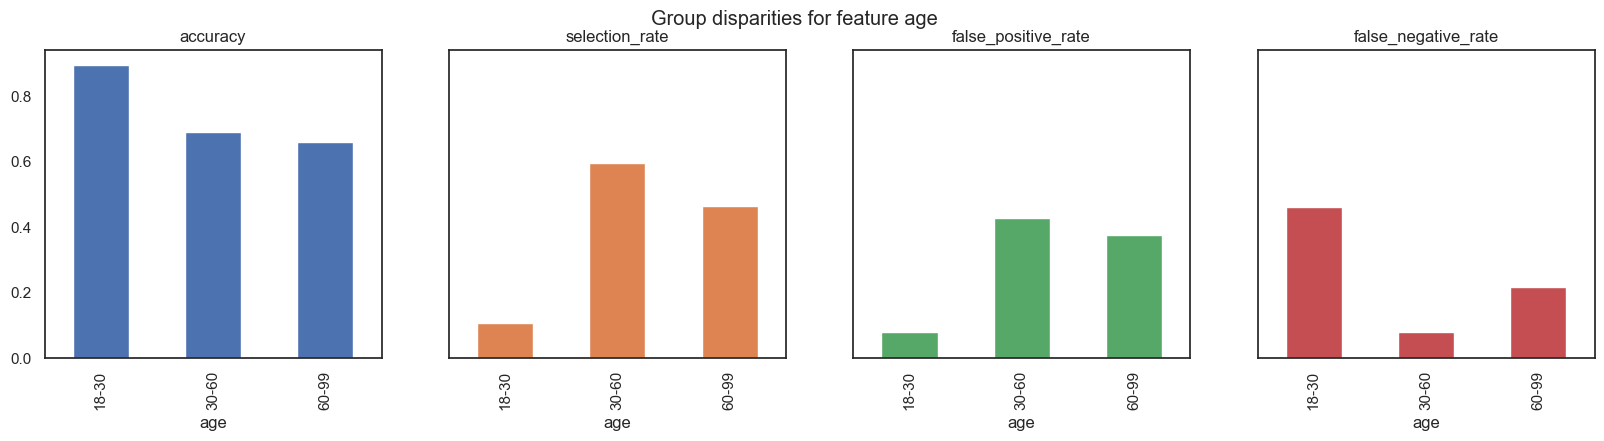

In [45]:
# plot fairness evaluation
for feature in selected_sensitive_features:
    
    metricframe_unmitigated = flm.MetricFrame(
        metrics=fairness_metrics,
        y_true=Y_test,
        y_pred=Y_pred,
        sensitive_features=A_test[feature],
        )

    print(f"Differences for feature {feature}:\n {metricframe_unmitigated.difference()}")

    metricframe_unmitigated.by_group.plot.bar(
        subplots=True,
        sharey = all,
        title=(f"Group disparities for feature {feature}"), 
        layout=[1, len(fairness_metrics)], 
        figsize=[20, 4], 
        legend=None
    )
    plt.show()

Notes:

* 

# Unfairness Mitigation

* **Balancing imbalanced data**: By oversampling underrepresented instances (e.g., black women), we can artificially increase the representation of underrepresented classes. Ideally, we should collect more data of underrepresented classes in order to improve performance for them.

* **Removing correlations with sensitive attributes**: If we want to nullify any influence of sensitive attributes, we should not only remove them from our data. Instead, we need to also account for correlations.

* **Penalty terms or regularization**: Introducing penalty terms or regularization for unwanted behavior (e.g, use of sensitive attributes) during the training process can guide models to pay particular attention to performance on the underrepresented class.

* **Optimizing for fairness metrics**: With the Fairlearn library we can optimize our classifiers to adhere to specified fairness metrics. However, due to the "impossibility of fairness" we need to make a judgement call about which metric to optimize.

* **Overruling decisions**: In human-AI hybrid settings, human experts can manually overrule a model's classification. They can account for contextual factors that are not captured in the data.

Since we are limited to simple programming, we will use the Fairlearn package to optimize a specified fairness metric.

<span style="color: blue; font-weight: bold;">TASK 7: How do you want to improve fairness? Which fairness metric do you want to optimize? How do the classifications change?</span>

## Optimizing for Fairness Metrics
Due to technical constraints, only `Linear Regression`, `DecisionTree` and `RandomForest` models can be enhanced with Fairlearn mitigations. Of course, you can also argue that optimizing for accuracy is the way to go anayways, which makes this section obsolete.
- `accuracy_score`: regular accuracy score
- `balanced_accuracy_score`: equal accuracy for all sensitive groups
- `demographic_parity` equalizes the rate of positively classified samples
- `true_positive_rate_parity`: equalizes true positive rates (corresponds to **equality of opportunity**)
- `false_positive_rate_parity`: equalizes false positive rates (in combination with the true positive rate this corresponds to **equalized odds**)

In [46]:
# select the primary training objective ("accuracy_score", "balanced_accuracy_score", "selection_rate", "true_positive_rate", "true_negative_rate")
primary_objective = "balanced_accuracy_score"

# select the equality metric you want to use as a constraint ("demographic_parity", "true_positive_rate_parity", "false_negative_rate_parity")
fairness_metric = "true_positive_rate_parity"

In [47]:
# train reconfigured model (only for lr, dt, and rf)
mitigated_model = ThresholdOptimizer(estimator=selected_model, constraints=fairness_metric, objective=primary_objective)
mitigated_model.fit(X_train, Y_train, sensitive_features=A_train)
Y_pred_mitigated = mitigated_model.predict(X_test, sensitive_features=A_test)

## Fairness Evaluation

Differences for feature race:
 accuracy               0.072251
selection_rate         0.147613
false_positive_rate    0.112024
false_negative_rate    0.056351
dtype: float64


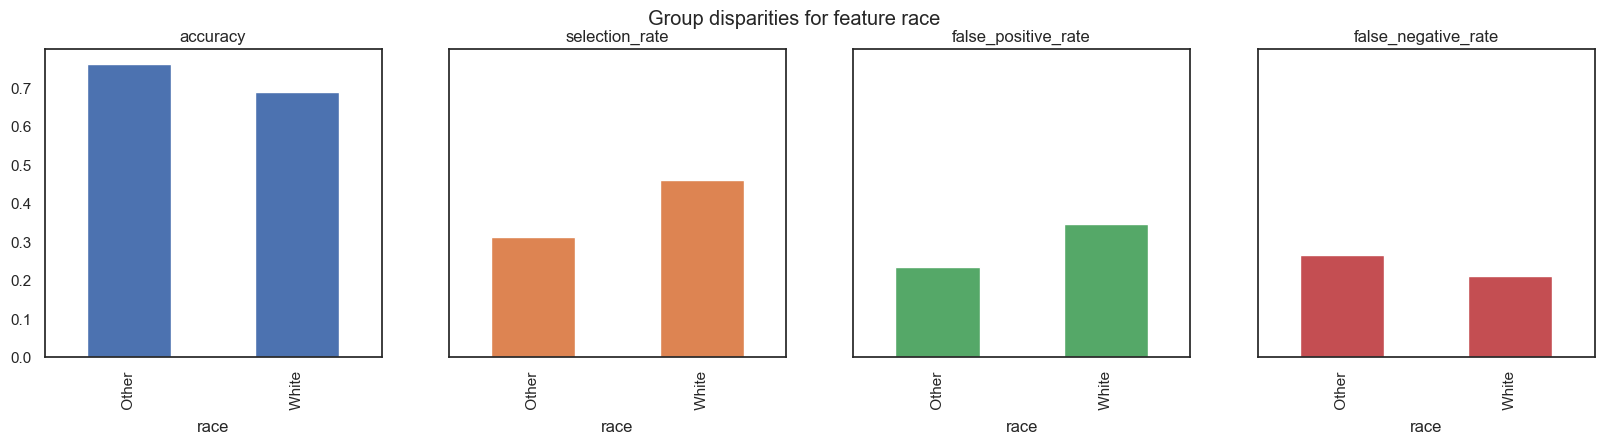

Differences for feature sex:
 accuracy               0.231238
selection_rate         0.370763
false_positive_rate    0.327865
false_negative_rate    0.100878
dtype: float64


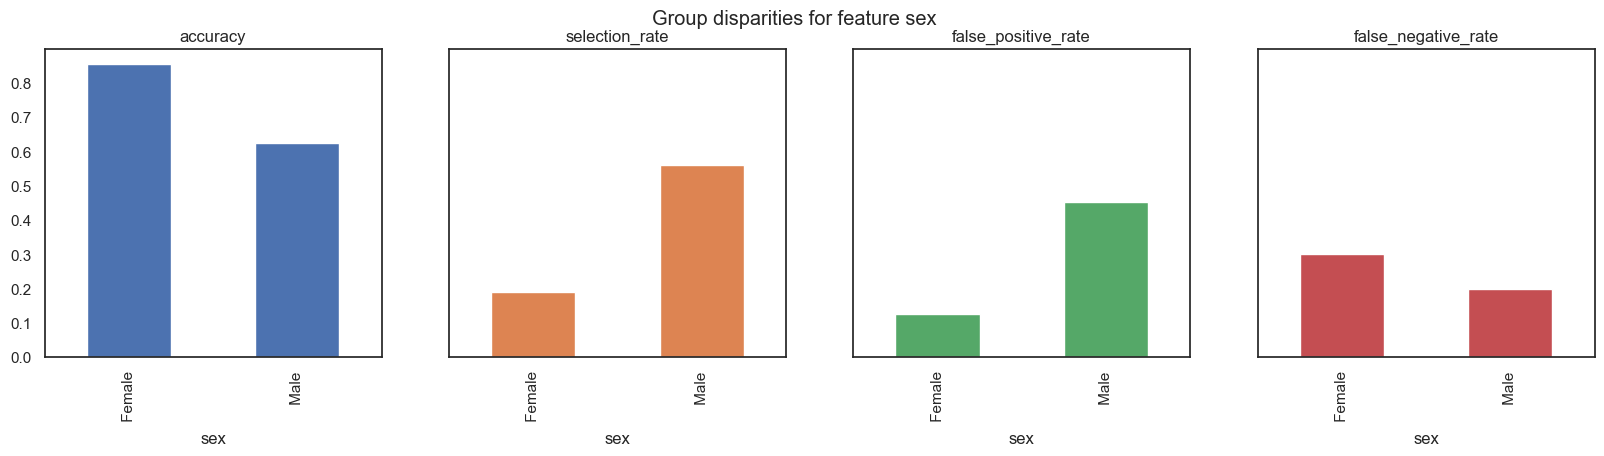

Differences for feature age:
 accuracy               0.139889
selection_rate         0.238562
false_positive_rate    0.160552
false_negative_rate    0.149399
dtype: float64


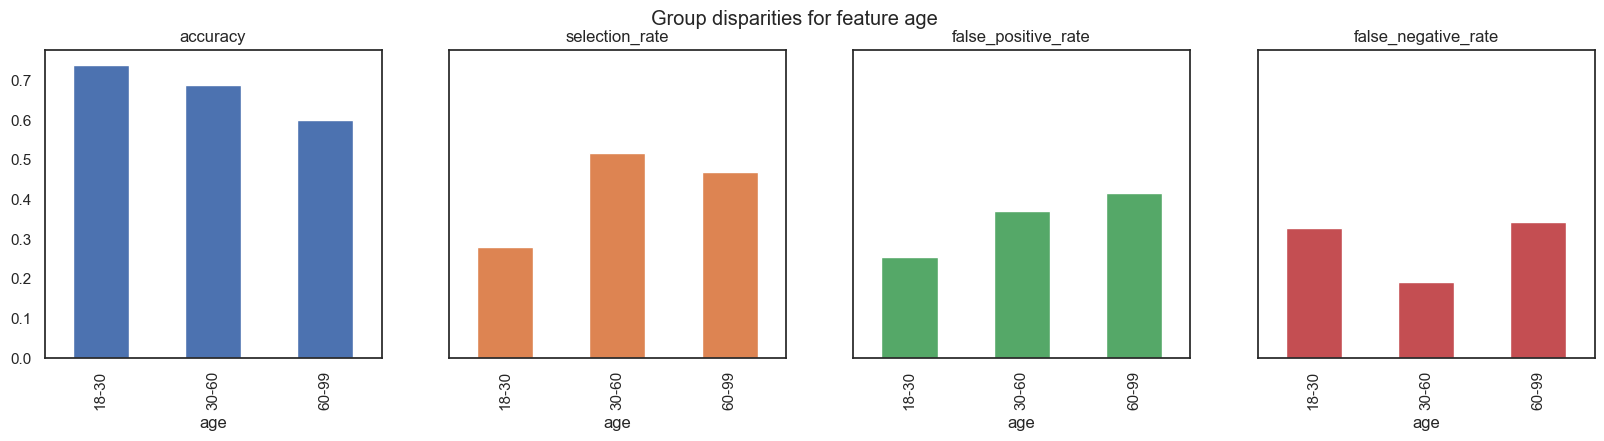

In [48]:
# plot fairness evaluation for reconfigured model (only for lr, dt, and rf)
for feature in selected_sensitive_features:

    metricframe_mitigated = flm.MetricFrame(
        metrics=fairness_metrics,
        y_true=Y_test,
        y_pred=Y_pred_mitigated,
        sensitive_features=A_test[feature],
        )

    print(f"Differences for feature {feature}:\n {metricframe_mitigated.difference()}")

    metricframe_mitigated.by_group.plot.bar(
        subplots=True,
        sharey = all,
        title=(f"Group disparities for feature {feature}"), 
        layout=[1, len(fairness_metrics)], 
        figsize=[20, 4], 
        legend=None
    )
    plt.show()

Notes:

* 

# Deployment

Finally, it is time to put your model into practice. Or is it?

<span style="color: blue; font-weight: bold;">TASK 8: Would you deploy your model in practice? If not, what would be required to do so? Would you maybe choose an entirely different approach to solve the use case?</span>

Notes:

* 